# Diabetic Retinopathy Detection

In a nutshell, DR is a eye complication that affects around 40% of people with diabetes, leading to blindness. If detected in time can be slowed down. 
This dataset is composed of features extracted from the output of several retinal image processing algorithms, such as:
- imagelevel (quality assessment, pre-screening, AM/FM)
- lesion-specific (microaneurysms, exudates) 
- anatomical (macula, optic disc) components. 
The actual decision about the presence of the disease is then made by comparing machine learning classifiers.


For this, I am going to compare three different classifier algorithms: logistic regression, Support vector machine and random forest. I am firstly going to use the tools and codes from the tutorials. After achiving a seeminly optimistic result, I will compare it to the outcome of the sklearn library. Finally, I will summarize my results. 

In [130]:
# Import necessary libraries
from encodings import search_function
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary tools from the sklearn library
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Import sklearn library tools used ONLY for validating my results
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, f1_score, accuracy_score, recall_score, precision_score, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from scipy.stats import randint as sp_randint
import warnings
warnings.filterwarnings('ignore')

In [131]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

In [132]:
def main():

    # read dataset from csv file
    data_name = "messidor_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.33, random_state=2200)
    return train_X, test_X, train_y, test_y, data_X, data_y

## Logistic Regression

In [133]:
class MyLogisticRegression:
    '''
    This is a class for Logistic Regression algorithm.
    
    The class contains the hyper parameters of the logistic regression algorithm as attributes.
    It also contains the functions for initializing the class, fitting the ridge regression model and use the fitted 
    model to predict test samples.
    
    Attributes:
        lr:        learning rate of gradient descent
        max_itr:   maximum number of iteration for gradient descent
        tol:       if the change in loss is smaller than tol, then we stop iteration
        W:         concatenation of weight w and bias b
        verbose:   whether or not print the value of logitic loss every 1000 iterations
        
    '''
    def __init__(self, lr=0.01, max_itr=100000, tol = 1e-5, verbose = False):
        self.lr = lr
        self.max_itr = max_itr
        self.tol = tol
        self.verbose = verbose
 
    def __sigmoid(self, z):
        '''
        Define the Sigmoid function to convert from real value to [0,1]
        
        Args: 
            z (matrix, num_samples*1): scores or real value
            
        Returns:
            A matrix (num_variables+1)*1: a value in the interval [0,1]
        '''
        return 1 / (1 + np.exp(-z))
    
    def __logistic_loss(self, h, y):
        '''
        Calculate the logistic loss
        '''
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, x, y):
        '''
        estimate the weight and bias in the logistic regression model by gradient descent
        
        Args: 
            x (matrix, num_train*num_variables): input of training samples
            y (matrix, num_test*1): labels of training samples, 0 or 1
            
        Returns:
            self.W (matrix, (num_variables+1)*1): estimation of weight and bias, i.e (w,b)
        '''
        ### Add the all-one vector to the last column 
        m = x.shape[0]
        X = np.concatenate((x, np.ones((m, 1))), axis=1)
        y = y.reshape(-1,1)
        # weight and bias initialization
        d = X.shape[1]
        self.W = np.zeros((d,1))
        
        z = np.dot(X, self.W)
        h = self.__sigmoid(z)
        previous_loss = self.__logistic_loss(h, y)
        for i in range(self.max_itr):
            ######################################
            ######################################
            ####### Write your codes below #######
            ### Calculate the gradient and update self.W
            p1 = np.divide(np.exp(np.dot(X, self.W)),(1+np.exp(np.dot(X,self.W))))
            
            grad = - 1/m * (np.dot(np.transpose(X),y-p1))

            self.W = self.W - self.lr * grad

            ######################################
            ######################################
            
            #Calculate the new logistic loss
            z = np.dot(X, self.W)
            h = self.__sigmoid(z)
            current_loss = self.__logistic_loss(h, y)
            if previous_loss - current_loss < self.tol:
                print('Converged after {} iterations'.format(i+1))
                print('Logistic loss after {} iterations is {}'.format(i+1,current_loss))
                break
            else:
                previous_loss = current_loss
            if(self.verbose == True and i % 10000 == 0):
                print('Logistic loss after {} iterations is {}'.format(i+1,current_loss))
        return self.W
    
    def predict_prob(self, x):
        '''
        predict the posterior probability p_1(x; W) of the test samples
        
        Args: 
            x (matrix, num_test*num_variables): input of test samples
            
        Returns:
            y (matrix, num_test*1): predicted posterior probability p_1(x; W) of test samples
        ''' 
        ######################################
        ######################################
        ####### Write your codes below #######
        m = x.shape[0]
        X = np.concatenate((x,np.ones((m,1))),axis=1)    
        y = np.divide(np.exp(np.dot(X, self.W)),(1+np.exp(np.dot(X,self.W))))
        
        return y
        ######################################
        ######################################
    
    def predict(self, x):
        '''
        predict the label of the test samples
        
        Args: 
            x (matrix, num_test*num_variables): input of test samples
            
        Returns:
            y (matrix, num_test*1): predicted labels of test samples, 0 or 1
        ''' 
        ######################################
        ######################################
        ####### Write your codes below #######
        m = x.shape[0]
        X = np.concatenate((x,np.ones((m,1))),axis=1)
        y = 1 / (1 + np.exp(-np.dot(X,self.W)))
        y = np.where(y>0.5,1,0)
        
        return y
        ######################################
        ######################################

In [134]:
def run():
    ### initiate the logistic regressor
    model = MyLogisticRegression(lr=0.1, max_itr=100000, tol = 1e-8, verbose=True)

    ### fit the model with training data and get the estimation of parameters (w & b)
    W = model.fit(main()[0], main()[2])

    ### Print the estimated w and b
    print(W.T)

    ### Print the estimated w and b
    print("The weight w of LR is \n {}.".format(W[:main()[1].shape[1],0].T))
    print("The bias b of LR is {}.".format(W[main()[1].shape[1],0]))

    y_pred = model.predict(main()[1])
    accuracy = np.sum(y_pred[:,0] == main()[3])/len(main()[3])

    ### Print the accuracy of the Logistic Regressor
    print("Accuracy of LR on the test dataset is {}.".format(accuracy))

In [137]:
run()

Logistic loss after 1 iterations is 0.6838623451102486
Logistic loss after 10001 iterations is 0.5100447489191648
Logistic loss after 20001 iterations is 0.4983314558736882
Logistic loss after 30001 iterations is 0.49234880920929286
Logistic loss after 40001 iterations is 0.4887060952482046
Logistic loss after 50001 iterations is 0.486286212261899
Logistic loss after 60001 iterations is 0.4845822765472486
Logistic loss after 70001 iterations is 0.4833318116095802
Logistic loss after 80001 iterations is 0.48238539816737697
Logistic loss after 90001 iterations is 0.4816515366397042
[[ 0.52244598 -0.29337878 17.03643152 -3.30565035 -9.06976625 -3.00483606
  -0.21214185  0.3362852   0.56957169 -0.21787326 -0.07485432 -0.59727419
   0.59130027 -1.73886879  1.80174032  0.50608556  0.08228581 -0.26506719
  -0.2188865   1.08788073]]
The weight w of LR is 
 [ 0.52244598 -0.29337878 17.03643152 -3.30565035 -9.06976625 -3.00483606
 -0.21214185  0.3362852   0.56957169 -0.21787326 -0.07485432 -0.59

I runned my model and obtained a 0.77% accuracy. Not bad for having selected random hyper-paramenters, but maybe with a better understanding of my dataset, some data-cleaning, and sklearn tool-kit can make the difference.  

In [136]:
# I am loading the full dataset and renaming the columns to keep better track of each attribute
data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "messidor_classification.csv")
df = pd.read_csv(data_path, header=0)
col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
             ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
             'euc_dist','diam_opt_disc','AM/FM','class_label']
df.columns = col_names
df.head(3)

,qual_assess,pre_screen,MA_detection_.5,MA_detection_.6,MA_detection_.7,MA_detection_.8,MA_detection_.9,MA_detection_1.0,exudate_detection_.3,exudate_detection_.4,exudate_detection_.5,exudate_detection_.6,exudate_detection_.7,exudate_detection_.8,exudate_detection_.9,exudate_detection_1.0,euc_dist,diam_opt_disc,AM/FM,class_label
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,b'0'
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,b'0'
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,b'1'


In [138]:
# I extract binary class in numeric form (1 or 0) from string.
df.class_label = df.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))

In [139]:
# Check for high correlation among features
df.corr()

,qual_assess,pre_screen,MA_detection_.5,MA_detection_.6,MA_detection_.7,MA_detection_.8,MA_detection_.9,MA_detection_1.0,exudate_detection_.3,exudate_detection_.4,exudate_detection_.5,exudate_detection_.6,exudate_detection_.7,exudate_detection_.8,exudate_detection_.9,exudate_detection_1.0,euc_dist,diam_opt_disc,AM/FM,class_label
qual_assess,1.000000,-0.017611,0.035576,0.035929,0.033395,0.036506,0.034817,0.031889,0.063597,0.063061,0.044449,0.027656,0.013336,0.011864,0.012695,0.012289,-0.021943,-0.067325,-0.051723,0.062816
pre_screen,-0.017611,1.000000,0.053300,0.054839,0.053056,0.059063,0.060557,0.060152,0.062930,0.052453,0.053534,0.041607,0.015900,0.018950,0.023268,0.023861,0.004751,-0.079577,0.010782,-0.076925
MA_detection_.5,0.035576,0.053300,1.000000,0.996177,0.985730,0.963149,0.925274,0.859620,-0.229653,-0.103047,-0.044650,0.103035,0.134464,0.142917,0.196550,0.208422,0.000001,0.033992,-0.344317,0.292603
MA_detection_.6,0.035929,0.054839,0.996177,1.000000,0.994221,0.977030,0.944504,0.883511,-0.244704,-0.115253,-0.058364,0.086486,0.117895,0.124198,0.172633,0.185645,0.001953,0.034714,-0.360716,0.266338
MA_detection_.7,0.033395,0.053056,0.985730,0.994221,1.000000,0.991821,0.968676,0.916198,-0.283188,-0.139111,-0.086595,0.057769,0.094513,0.098859,0.140774,0.156441,0.000387,0.030396,-0.389384,0.234691
MA_detection_.8,0.036506,0.059063,0.963149,0.977030,0.991821,1.000000,0.988294,0.947860,-0.309950,-0.160011,-0.109946,0.029768,0.067477,0.069797,0.102638,0.119405,0.001520,0.016854,-0.411806,0.197511
MA_detection_.9,0.034817,0.060557,0.925274,0.944504,0.968676,0.988294,1.000000,0.974577,-0.349811,-0.197279,-0.152578,-0.020469,0.022265,0.024959,0.050579,0.070735,-0.001725,0.010961,-0.437036,0.161631
MA_detection_1.0,0.031889,0.060152,0.859620,0.883511,0.916198,0.947860,0.974577,1.000000,-0.375506,-0.223681,-0.181197,-0.058153,-0.012400,-0.012175,0.006868,0.031520,-0.002557,-0.011607,-0.435127,0.127861
exudate_detection_.3,0.063597,0.062930,-0.229653,-0.244704,-0.283188,-0.309950,-0.349811,-0.375506,1.000000,0.767091,0.763409,0.486606,0.163915,0.132227,0.114722,0.084682,-0.086155,-0.086474,0.390304,0.058015
exudate_detection_.4,0.063061,0.052453,-0.103047,-0.115253,-0.139111,-0.160011,-0.197279,-0.223681,0.767091,1.000000,0.919589,0.624537,0.257159,0.216127,0.181431,0.139196,-0.128990,-0.090721,0.291554,0.000479


<AxesSubplot:>

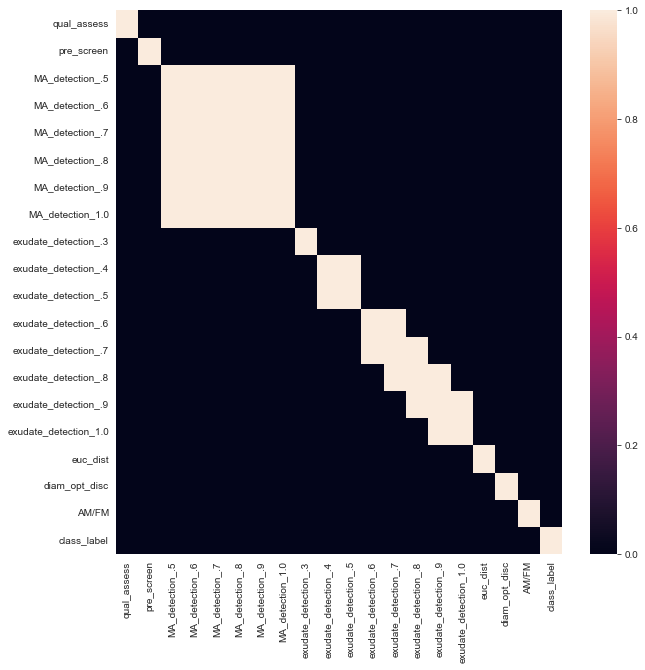

In [140]:
# Heatmap of correlation above 0.8.
fig = plt.figure(figsize = (10,10))
sns.heatmap(abs(df.corr()) > .8)

Correlation heatmaps give me a visual understanding of the importance of the dataset attributes. Here, I can see that there is a high correlation with all MA_detection attributes and therefore, I could choouse only one along them to continue.  

I could search for the best MA featuresby running 6 different datasets, each keeping a different MA feature. Yet I am just going to assume MA5 works best and move along. To do so, I specify the MA columns I want to drop, all but MA5. I also drop every other exudate
detection column for all datasets. This will eliminate correlation among exudate features.

In [141]:
df_MA5 = df.copy()
drop_5 = ['MA_detection_1.0','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']

In [142]:
# Drop appropriate columns to create these dataframes.
df_MA5.drop(columns = drop_5, inplace = True)

# Check to make sure the desired result is achieved. 
print(df_MA5.columns)

Index(['qual_assess', 'pre_screen', 'MA_detection_.5', 'exudate_detection_.3',
       'exudate_detection_.5', 'exudate_detection_.7', 'exudate_detection_.9',
       'euc_dist', 'diam_opt_disc', 'AM/FM', 'class_label'],
      dtype='object')


<AxesSubplot:>

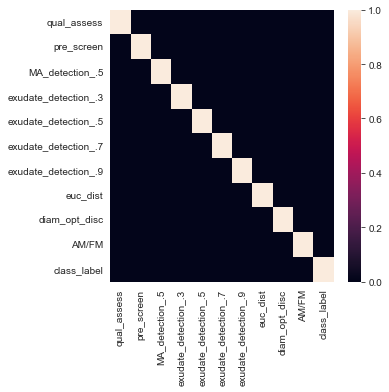

In [143]:
# Check the correlation of MA5 dataframe. 

fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA5.corr()) > .8)

# Prepare data for classification.

In [146]:
# Divide each new dataframe between variables and target. 

X = df.iloc[:,0:-1]
y = df.class_label

X_MA5 = df_MA5.iloc[:,0:-1]
y_MA5 = df_MA5.class_label

In [147]:
# Perform a test-train split for each dataframe.

X_train_MA5, X_test_MA5, y_train_MA5, y_test_MA5 = train_test_split(X_MA5,y_MA5, 
                                                                    test_size = .33, 
                                                                    random_state = 27,
                                                                    stratify = y_MA5)

                                                                    
train_sets = {'MA=.5_train':(X_train_MA5,y_train_MA5)}


AUC: 0.7248581599733006


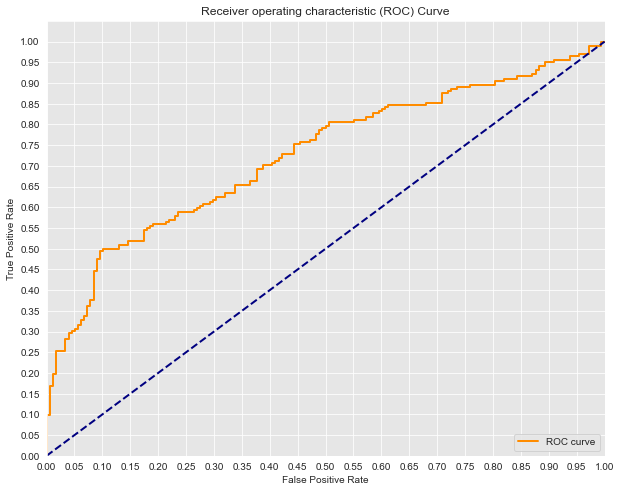

In [148]:
# Generate ROC curve. 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_LR, tpr_LR)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_LR, tpr_LR, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Support Vector Machine

We have now obtained an accuracy of 77% with our Logistic Regression algorithm. Lets's see if we can improve it using SVM. I have already imported all the libraries, so lets  head right into data preparation. Remember I am first using the code from the tutorial and then looking if I can improve my results with the sklearn library. 

## Data preparation

In [152]:
# # I will clean a little bit the data to binarize the class results.  
# data_dir = "..\..\..\data\data_classification"
# data_path = os.path.join(data_dir, "messidor_classification.csv")
# df = pd.read_csv(data_path, header=0)
# # I extract binary class in numeric form (1 or 0) from string.
# df.Class = df.Class.apply(lambda x: pd.to_numeric(str(x)[2]))

# print(df['Class'])

## Data Preprocessing

In order to improve our performance, we want to make sure that the data we are dealing with is good. This means, there is no missing data, we are aware of the data types, and we fix possible mistakes. 

In [153]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path, header=1)
    print(df)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

In [154]:
def main():
    
    # read dataset from csv file
    data_name = "messidor_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    return data_X, data_y


In [155]:
x, y = main()
dfx = pd.DataFrame(x) 
dfy = pd.DataFrame(y) 

      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

In [84]:
# dfx.dtypes
col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
             ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
             'euc_dist','diam_opt_disc','AM/FM']
dfx.columns = col_names

dfy.rename({0:'class_label'}, axis='columns', inplace=True) 
dfy.head()


,class_label
0,0
1,1
2,0
3,1
4,1


## Implementation of SVM

We choose the Gaussian kernel (RBF kernel) for SVM. For any $x_i, x_j \in\mathbb{R}^d$, we define
$$
\kappa(x_i, x_j) = \exp \bigl( - \|x_i - x_j\|^2 / (2 \sigma^2) \bigr)
$$ 
where $\sigma > 0$ is the width of the Gaussian kernel.

In [156]:
class SVM():
    '''
    This is a class for support vector machine.
    
    The class contains the hyper-parameters such as $C$ and the kernel bandwidth $\sigma$. It also contains 
    the alpha vector, the tolerance for prediction error and the maximum number of iteration.
    
    It contains the functions for calculating the kernel matrix, fitting the model to estimate alpha and b 
    with SMO algorithm, making predictions and other fundamental functions.
    
    Attributes:
        C (positive number)         - the hyperparameter for SVM algorithm
        sigma (positive number)     - the kernel bandwidth $\sigma$ of Gaussian kernel 
        toler (positive number)     - the threshold value of prediction error. If the prediction error of 
                                      a sample is larger than this value, the corresponding alpha_i will be 
                                      probably updated.
        maxIter (positive integer)  - the maximum number of iteration to search a pair of alpha's to update
        alphas (vector, num_samples)- the alpha vector in the dual problem 
        b (number)                  - the bias b
    '''
    
    def __init__(self, C = 1, sigma = 1, toler = 0.01, maxIter = 100):
        self.C = C
        self.sigma = sigma
        self.toler = toler
        self.maxIter = maxIter
        self.alphas = 0
        self.b = 0
        
    def rbfkernel(self, X, Y):
        '''
        Calculate the kernel matrix whose (i,j)-th entry is $k(X[i,:], Y[j,:])$.
        '''
        m = X.shape[0]
        n = Y.shape[0]
        K = np.zeros(shape=(m, n))
        for i in range(m):
            for j in range(n):
                K[i, j] = np.sum((X[i,:] - Y[j,:])**2)
        K = np.exp(-K / (2 * self.sigma**2))
        return K

    def selectJrand(self, i, m):
        '''
        Randomly choose an index $j\neq i$ from 0 to m-1
        '''
        j = i 
        while (j == i):
            j = int(np.random.uniform(0, m))
        return j


    def clipAlpha(self, aj, H, L):
        '''
        Clip the vale aj by the lower bound L and upper bound H
        '''
        if aj > H:
            aj = H
        if L > aj:
            aj = L
        return aj


    def fit(self, X_train, y_train):
        '''
        estimate the alphas vector and bias in the SVM model
        
        Args: 
            X_train (matrix, num_train*num_features): features of training samples
            y_train (vector, num_train): label of training samples, each label is either -1 or 1
            
        Returns:
            self.b (a number)                 : the bias
            self.alphas (vector, num_features): the alpha vector 
        ''' 
        K_train = self.rbfkernel(X_train, X_train)
        self.X_train = X_train
        self.y_train = y_train
        m = K_train.shape[0]
        self.alphas = np.zeros((m, ))
        num_iter = 0
        while (num_iter < self.maxIter):
            alphaPairsChanged = 0
            # optimize for each data vector (with kernel trick)
            for i in range(m):   
                fXi = (self.alphas * y_train) @ K_train[i, :] + self.b
                # if checks if an example violates KKT conditions
                Ei = fXi - y_train[i]
                if ((y_train[i] * Ei < -self.toler) and (self.alphas[i] < self.C)) \
                       or ((y_train[i] * Ei > self.toler) and (self.alphas[i] > 0)):
                    j = self.selectJrand(i, m)
                    fXj = (self.alphas * y_train) @ K_train[j, :] + self.b
                    Ej = fXj - y_train[j]
                    alphaJold = self.alphas[j].copy()
                    alphaIold = self.alphas[i].copy()
                    if (y_train[j] != y_train[i]):
                        L = max(0, self.alphas[i] - self.alphas[j])
                        H = min(self.C, self.C + self.alphas[i] - self.alphas[j])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])
                    if L == H:
                        continue
                    eta = 2.0 * K_train[j, i] - K_train[j, j] - K_train[i, i]
                    if eta >= 0:
                        continue
                    self.alphas[i] += y_train[i] * (Ei - Ej) / eta
                    self.alphas[i] = self.clipAlpha(self.alphas[i], H, L)
                    if (abs(self.alphas[i] - alphaIold) < 0.00001):
                        continue
                    # update i by the same amount as j, the direction depends on y[i] and y[j]
                    self.alphas[j] += y_train[i] * y_train[j] * (alphaIold - self.alphas[i])
                    # update self.b
                    b1 = self.b - Ej - y_train[j] * (self.alphas[j] - alphaJold) * K_train[
                        j, j] - y_train[i] * (self.alphas[i] - alphaIold) * K_train[j, i]
                    b2 = self.b - Ei - y_train[j] * (self.alphas[j] - alphaJold) * K_train[
                        j, i] - y_train[i] * (self.alphas[i] - alphaIold) * K_train[i, i]
                    if (0 < self.alphas[j]) and (self.C > self.alphas[j]): self.b = b1
                    elif (0 < self.alphas[i]) and (self.C > self.alphas[i]): self.b = b2
                    else: self.b = (b1 + b2) / 2.0
                    alphaPairsChanged += 1
            if (alphaPairsChanged == 0): num_iter += 1
            else: num_iter = 0
        return self.b, self.alphas


    def predict(self,X_test):
        '''
        predict the label of test samples
        Args:
            X_test(matrix, num_test*num_features): features of test samples
        Returns:
            y_hat(vector, num_test): the predicted label of test samples, each label is either -1 or 1
        '''
        K_test = self.rbfkernel(self.X_train, X_test)
        f = K_test.T @ (self.alphas * self.y_train) + self.b
        y_hat = np.sign(f)
        return y_hat

## Run SVM on the dataset

In [157]:
def t_t():
    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(main()[0], main()[1], test_size=0.33, random_state=100)
    return train_X, test_X, train_y, test_y

In [158]:
clf_svm = SVC(random_state=42)
clf_svm.fit(t_t()[0], t_t()[2])

      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

SVC(random_state=42)

      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

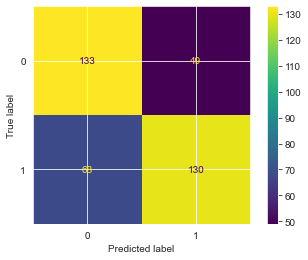

In [159]:
plot_confusion_matrix(clf_svm,t_t()[1],  t_t()[3], values_format='d')

In [160]:
param_grid = [{'C':[0.5, 1, 10, 100], 'gamma': ['scale', 1, 0.1, 0.01, 0.001], 'kernel': ['rbf'] }]

In [161]:
from sklearn.model_selection import GridSearchCV

optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv = 5,
                             scoring = 'accuracy' )

optimal_params.fit(t_t()[0], t_t()[2])
print(optimal_params.best_params_)




      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

In [162]:
clf_svm = SVC(random_state=42, C = 100, gamma=0.01)
clf_svm.fit(t_t()[0], t_t()[2])

      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

SVC(C=100, gamma=0.01, random_state=42)

      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

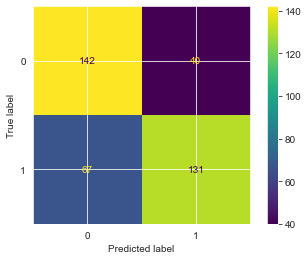

In [163]:
plot_confusion_matrix(clf_svm,t_t()[1],  t_t()[3], values_format='d')

In [164]:
pca = PCA()

In [165]:
def run():
    # running the model and getting the accuracy
    model_SVM = SVM(C = 100, sigma = 2, toler=0.001, maxIter=40)
    b, alphas = model_SVM.fit(t_t()[0], t_t()[2])
    y_test_hat = model_SVM.predict(t_t()[1])
    accuracy = np.mean(y_test_hat == t_t()[3])
    print("The accuracy of SVM is:", accuracy)

In [166]:
run()

      1.0  1.0.1  22.0  22.0.1  22.0.2  19.0  18.0  14.0  49.895756  \
0     1.0    1.0  24.0    24.0    22.0  18.0  16.0  13.0  57.709936   
1     1.0    1.0  62.0    60.0    59.0  54.0  47.0  33.0  55.831441   
2     1.0    1.0  55.0    53.0    53.0  50.0  43.0  31.0  40.467228   
3     1.0    1.0  44.0    44.0    44.0  41.0  39.0  27.0  18.026254   
4     1.0    1.0  44.0    43.0    41.0  41.0  37.0  29.0  28.356400   
...   ...    ...   ...     ...     ...   ...   ...   ...        ...   
1145  1.0    1.0  34.0    34.0    34.0  33.0  31.0  24.0   6.071765   
1146  1.0    1.0  49.0    49.0    49.0  49.0  45.0  37.0  63.197145   
1147  1.0    0.0  49.0    48.0    48.0  45.0  43.0  33.0  30.461898   
1148  1.0    1.0  39.0    36.0    29.0  23.0  13.0   7.0  40.525739   
1149  1.0    1.0   7.0     7.0     7.0   7.0   7.0   5.0  69.423565   

      17.775994    5.27092  0.771761  0.018632  0.006864  0.003923  \
0     23.799994   3.325423  0.234185  0.003903  0.003903  0.003903   
1     2

I am clearly doing something wrong here, so let's see what the sklearn library can offered me to resolve it:


In [167]:
# I again use the processed data from the logistic regression but this time I specify SVC

SVM_best_scores = {}

for key, val in train_sets.items():
    preprocess = preprocess_dict[key+'_scaled']
    model = make_pipeline(preprocess, SVC())
    params = {
              
              'svc__C': [.01,.01,.1,1,10,100,1000],
              'svc__gamma':['auto',.0001,.001,.01,.1,1,10,100], 
              'svc__class_weight':['balanced',None]
              }

    search_svm = GridSearchCV(estimator = model, param_grid = params,
                     cv = 5, return_train_score = True,
                      n_jobs = -1)

    search_svm.fit(val[0], val[1])
    SVM_best_scores[key] = {'model':search_svm, 'best_params':search_svm.best_params_,
                           'best_score':search_svm.best_score_}

In [168]:
# See which dataframe varying by MA detection feature had the best score. 

for key in train_sets.keys():
    print(key, ': ',LR_best_scores[key]['best_score'])

MA=.5_train :  0.6666191872643485


In [169]:
SVM_best_scores['MA=.5_train']['best_params']

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'auto'}

In [171]:
# Generate classifier metrics for this optimal classifier. 

y_hat_test_MA5_SVM = SVM_best_scores['MA=.5_train']['model'].predict(X_test_MA5)
print('Suppot vector machine')
print('Accuracy Score: ', accuracy_score(y_test_MA5,y_hat_test_MA5_SVM))
print('Precision Score: ', precision_score(y_test_MA5,y_hat_test_MA5_SVM))
print('Recall Score: ', recall_score(y_test_MA5,y_hat_test_MA5_SVM))
print('F1 Score: ',f1_score(y_test_MA5,y_hat_test_MA5_SVM))

Suppot vector machine
Accuracy Score:  0.6605263157894737
Precision Score:  0.7552447552447552
Recall Score:  0.5346534653465347
F1 Score:  0.6260869565217392


In [172]:
# Prepare model for ROC curve. 

y_scores_SVM = SVM_best_scores['MA=.5_train']['model'].decision_function(X_test_MA5)
fpr_SVM, tpr_SVM, threshold_SVM = roc_curve(y_test_MA5, y_scores_SVM)

AUC: 0.7295027255534542


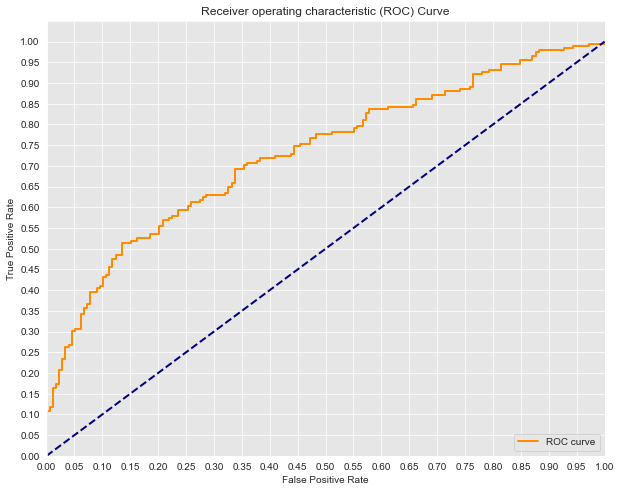

In [173]:
# Generate ROC curve. 

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_SVM, tpr_SVM)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_SVM, tpr_SVM, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forrest

In [116]:
# I am loading the full dataset and renaming the columns to keep better track of each attribute
data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "messidor_classification.csv")
df = pd.read_csv(data_path, header=0)
col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
             ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
             'euc_dist','diam_opt_disc','AM/FM','class_label']
df.columns = col_names
df.head(3)

,qual_assess,pre_screen,MA_detection_.5,MA_detection_.6,MA_detection_.7,MA_detection_.8,MA_detection_.9,MA_detection_1.0,exudate_detection_.3,exudate_detection_.4,exudate_detection_.5,exudate_detection_.6,exudate_detection_.7,exudate_detection_.8,exudate_detection_.9,exudate_detection_1.0,euc_dist,diam_opt_disc,AM/FM,class_label
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,b'0'
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,b'0'
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,b'1'


In [119]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path, header=1)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

In [117]:
# Divide each new dataframe between variables and target. 

X = df.iloc[:,0:-1]
y = df.class_label

X_MA5 = df_MA5.iloc[:,0:-1]
y_MA5 = df_MA5.class_label

In [118]:
# Perform a test-train split for each dataframe.

X_train_MA5, X_test_MA5, y_train_MA5, y_test_MA5 = train_test_split(X_MA5,y_MA5, 
                                                                    test_size = .33, 
                                                                    random_state = 27,
                                                                    stratify = y_MA5)

                                                                    
train_sets = {'MA=.5_train':(X_train_MA5,y_train_MA5)}


In [120]:

def main():

    # read dataset from csv file
    data_name = "messidor_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    # Train and test set
    # kf = KFold(n_splits=10)
    # res_list = []
    # for train_index, test_index in kf.split(data_X):
    #     train_X, train_y = data_X[train_index,:], data_y[train_index]
    #     test_X, test_y = data_X[test_index,:], data_y[test_index]
    return data_X, data_y

In [121]:
data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "abalone_classification.csv")
df = pd.read_csv(data_path, header=0)

print(df.head())

       1      2      3       4       5       6      7  0_F  0_I  0_M   8
0  0.455  0.365  0.095  0.5140  0.2245  0.1010  0.150    0    0    1  15
1  0.350  0.265  0.090  0.2255  0.0995  0.0485  0.070    0    0    1   7
2  0.530  0.420  0.135  0.6770  0.2565  0.1415  0.210    1    0    0   9
3  0.440  0.365  0.125  0.5160  0.2155  0.1140  0.155    0    0    1  10
4  0.330  0.255  0.080  0.2050  0.0895  0.0395  0.055    0    1    0   7


## Criterion -- Gini Index

In [122]:
def calculate_weighted_counts(y, sample_weight, classes_):
    '''
    the function used to calculate the summation of weights of samples from each class. Generally speaking,
    the weights are all set as one. But for Adaboost, each sample has different values.
    '''
    class_counts = np.zeros(shape=classes_.shape[0], dtype=np.float64)
    for i, label in enumerate(classes_):
        idx = y == label
        if idx.sum() > 0:
            class_counts[i] = sample_weight[idx].sum()
        else:
            class_counts[i] = 0
    return class_counts

def gini(y, sample_weight):
    classes_ = np.unique(y)
    class_counts = calculate_weighted_counts(y, sample_weight, classes_)
    if class_counts.sum() > 0:
        pk = class_counts / class_counts.sum()
        pk = pk[pk > 0]
        return 1 - np.sum(pk**2)
    else:
        return 0

def gini_index(X, y, feat, point, sample_weight):
    '''
    calculate the difference of gini index before and after splitting
    '''
    S = gini(y, sample_weight)
    new_S = 0
    n = sample_weight.sum()
    assert n > 0
    idx1 = X[:, feat] < point
    nv = sample_weight[idx1].sum()
    if nv > 0:
        new_S += nv / n * gini(y[idx1], sample_weight[idx1])
    idx2 = X[:, feat] >= point
    nv = sample_weight[idx2].sum()
    if nv > 0:
        new_S += nv / n * gini(y[idx2], sample_weight[idx2])
    return S - new_S

# 3. Decision Trees for Classification

Different from the classification tree implemented in the last tutorial:
1. Each internal node has two child nodes regardless of values of the splitting feature are continuous or discrete.
2. Add the parameter `max_depth` for providing another condition to stop splitting procedures.
3. Add the parameter `max_features` to use the subset of features to build decision tree.

Options 2&3 are designed for constructing trees in the random forest implemented in Section 5. 

If you'd like to build the classification tree, you can ignore options 2&3 by setting `max_depth = None` and `max_features = None`. Then we can combine it with the pre-pruning or post-pruning technique implemented in Section 4 to prevent overfitting.

In [123]:
class DecisionTreeClassifier(object):
    '''
    This class is for classification tree

    Attributes:
        - criterion: a function used as the criterion of classification tree
        - tree: a nested dictionary representing the decision tree structure.
        - max_depth: the parameter to control the depth of tree. If the depth is larger than max_depth, we will stop splitting.
        - max_feature: the number of selected features to build decision tree
    '''
    def __init__(self,
                 criterion=gini_index,
                 max_depth=None,
                 max_features=None,
                 random_seed=None):
        self.f_criterion = criterion
        self.max_depth = max_depth
        if self.max_depth is None:
            self.max_depth = 2**10
        self.max_features = max_features
        self.random_seed = random_seed

    def fit(self, X, y, sample_weight=None):
        np.random.seed(self.random_seed)
        num_samples, num_features = X.shape
        if self.max_features is None:
            self.max_features = num_features
        elif self.max_features == "sqrt":
            self.max_features = np.int(np.round(np.sqrt(num_features)))
        self.classes_ = np.unique(y)
        if sample_weight is None:
            sample_weight = np.ones(num_samples, dtype=np.float64)
        # build the decision tree
        self.tree = self.create_tree(X, y, sample_weight, depth=0)

    def create_tree(self, X, y, sample_weight, depth):
        Tree = {}
        Tree["depth"] = depth
        class_counts = calculate_weighted_counts(y, sample_weight, self.classes_)
        # create a leaf node if all samples belong to the same class
        if (class_counts != 0).sum() == 1:
            Tree["is_leaf"] = True
            Tree["pred"] = self.classes_[class_counts != 0]
        # using the majority vote to get the prediction at each node
        majority_class = self.classes_[np.argmax(class_counts)]
        Tree["pred"] = majority_class
        # create a leaf node if feature set is empty
        feat, point = self.choose_best_split(X, y, sample_weight)
        if feat is None or depth == self.max_depth:
            Tree["is_leaf"] = True
            return Tree
        # otherwise, create an internal node
        Tree["is_leaf"] = False
        Tree["split_feat"] = feat
        Tree["split_point"] = point
        # build the left subtree
        idx = X[:, feat] < point
        Tree["left"] = self.create_tree(X[idx], y[idx], sample_weight[idx],
                                        depth + 1)
        # build the right subtree
        idx = X[:, feat] >= point
        Tree["right"] = self.create_tree(X[idx], y[idx], sample_weight[idx],
                                         depth + 1)
        return Tree

    def choose_best_split(self, X, y, sample_weight):
        # initialization
        best_feat, best_point = None, None
        best_score = 0.0
        # search for each candidate feature
        num_features = X.shape[1]
        if self.max_features < num_features:
            candidate_feat = np.random.permutation(
                num_features)[:self.max_features]
        else:
            candidate_feat = np.arange(num_features)
        for feat in candidate_feat:
            # if all values of this feature are equal, do not split this feature
            X_feat_value = np.unique(X[:, feat])
            if len(X_feat_value) == 1:
                continue
            # search for each possible split point
            for i in range(len(X_feat_value) - 1):
                # divide the dataset into two parts according to the split
                point = (X_feat_value[i] + X_feat_value[i + 1]) / 2.0
                # calculate score to evaluate the quality of a split
                score = self.f_criterion(X, y, feat, point, sample_weight)
                if score > best_score:
                    best_feat = feat
                    best_point = point
                    best_score = score
        return best_feat, best_point

    def predict(self, X):
        '''
        function used to fit the decision tree classifier

        Args:
            X - features of test samples, a pandas dataframe with shape (n, d)

        Returns:
            y - predictions of test samples, a pandas series with shape (n,)
        '''
        n = X.shape[0]
        y = []
        for i in range(n):
            y.append(DecisionTreeClassifier.predict_each(X[i], self.tree))
        y = np.array(y, dtype=np.int32)
        return y

    @staticmethod
    def predict_each(x, tree):
        '''
        for each sample, get the prediction of decision tree classifier in a recursive manner.

        Args:
            x - features of a sample, a pandas Series with shape (d,)
            tree - a nested dictionary representing the decision tree structure.

        Returns:
            the prediction of the sample `x`
        '''
        if tree["is_leaf"] is True:
            # if the `tree` is a leaf node, get the prediction at the leaf node
            return tree["pred"]
        else:
            # the 'tree' is a nested dictionary
            # get the value of the feature used to split
            feat = tree["split_feat"]
            point = tree["split_point"]
            # get the value of the feature for the sample `x`
            value = x[feat]
            if value < point:
                return DecisionTreeClassifier.predict_each(x, tree["left"])
            else:
                return DecisionTreeClassifier.predict_each(x, tree["right"])

In [124]:
def t_t():
    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(main()[0], main()[1], test_size=0.33, random_state=100)
    return train_X, test_X, train_y, test_y

In [125]:
X_train, X_test, y_train, y_test = t_t()
model = DecisionTreeClassifier(criterion=gini_index,
                                   max_depth=None,
                                   max_features=None,
                                   random_seed=None)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("The accuracy of training data is:", acc_train)
print("The accuracy of test data is:", acc_test)

The accuracy of training data is: 1.0
The accuracy of test data is: 0.6447368421052632


You maybe find that the accuracy of training data is almost one but the accuracy of test data is low. The reason is that the decision tree overfits to the training data. To prevent overfitting, we introduce the post-pruning technique in the next section.

# 4. Classification Tree with the Pruning Technique

In [126]:
def pruning(tree, classes_, X_valid, y_valid):
    '''
    the function used to post-prune the decision tee

    Args:
        tree - a nested dictionary representing the decision tree structure.
        classes_ - names of all classes 
        X_valid - the features of the validation samples
        y_valid - the labels of the validation samples
    Returns:
        the tree structure after pruning
   '''
    if X_valid.shape[0] == 0:
        new_tree = {}
        new_tree["is_leaf"] = True
        new_tree["pred"] = tree["pred"]
        return new_tree
    if tree["is_leaf"] is True:
        return tree
    feat = tree["split_feat"]
    point = tree["split_point"]
    idx1 = X_valid[:, feat] < point
    tree["left"] = pruning(tree["left"], classes_, X_valid[idx1],
                           y_valid[idx1])
    idx2 = X_valid[:, feat] >= point
    tree["right"] = pruning(tree["right"], classes_, X_valid[idx2],
                            y_valid[idx2])
    if tree["left"]["is_leaf"] is True and tree["right"]["is_leaf"] is True:
        FLAG = True
    else:
        FLAG = False
    if FLAG:
        # check validation accuracy gap
        valid_y_true = []
        valid_y_pred = []
        # make prediction and calculate validation accuracy of the tree before merging
        child_majority_class = tree["left"]["pred"]
        idx1 = X_valid[:, feat] < point
        if idx1.sum() > 0:
            valid_y_true.append(y_valid[idx1])
            valid_y_pred.append([child_majority_class] * idx1.sum())
        child_majority_class = tree["right"]["pred"]
        idx2 = X_valid[:, feat] >= point
        if idx2.sum() > 0:
            valid_y_true.append(y_valid[idx2])
            valid_y_pred.append([child_majority_class] * idx2.sum())
        valid_y_true = np.concatenate(valid_y_true)
        valid_y_pred = np.concatenate(valid_y_pred)
        valid_acc_before = np.mean(valid_y_true == valid_y_pred)
        # make prediction and calculate validation accuracy of the tree after merging
        majority_class = tree["pred"]
        valid_y_pred = np.array([majority_class] * X_valid.shape[0])
        valid_acc_after = np.mean(valid_y_true == valid_y_pred)
        # if the validation accuracy after merging is larger, we will prune
        if valid_acc_after > valid_acc_before:
            new_tree = {}
            new_tree["is_leaf"] = True
            new_tree["pred"] = tree["pred"]
            return new_tree
        else:
            return tree
    else:
        return tree

In [127]:
X_train, X_test, y_train, y_test = t_t()
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.3,
                                                      stratify=y_train,
                                                      random_state=3147)
model = DecisionTreeClassifier(criterion=gini_index,
                                   max_depth=None,
                                   max_features=None,
                                   random_seed=None)
model.fit(X_train, y_train)
# without pruning
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_valid = (y_valid == y_valid_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("Training accuracy of the classification tree Without pruning is:", acc_train)
print("Validation accuracy of the classification tree Without pruning is:", acc_valid)
print("Testing accuracy of the classification tree Without pruning is:", acc_test, '\n')
# with pruning
model.tree = pruning(model.tree, model.classes_, X_valid, y_valid)
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_valid = (y_valid == y_valid_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("Training accuracy of the classification tree With pruning is:", acc_train)
print("Validation accuracy of the classification tree With pruning is:", acc_valid)
print("Testing accuracy of the classification tree With pruning is:", acc_test)

Training accuracy of the classification tree Without pruning is: 1.0
Validation accuracy of the classification tree Without pruning is: 0.5714285714285714
Testing accuracy of the classification tree Without pruning is: 0.6342105263157894 

Training accuracy of the classification tree With pruning is: 0.974025974025974
Validation accuracy of the classification tree With pruning is: 0.6017316017316018
Testing accuracy of the classification tree With pruning is: 0.6289473684210526


# 5. Random Forest for Classification

In this section, we implement the random forest where each tree is built with the class DecisionTreeClassifier(). In our model, the values of parameters are listed below. 
1. The number of trees $T$ is set as ``num_estimators = 20``
2. the number of subsampled features for each tree is $k =\sqrt{d}$, which corresponds to ``max_features = "sqrt"`` in the code.
3. The maximum depth of each tree is ``max_depth = 6``.

We will not use the pruning technique for each tree in the random forest.

In [128]:
class RandomForestClassifier(object):
    '''
    This class is for random forest classification

    Attributes:
        - criterion: a function used as the criterion of classification tree
        - num_estimators: the number of trees in the random forest 
        - tree: a nested dictionary representing the decision tree structure
        - max_depth: the parameter to control the depth of tree. If the depth is larger than max_depth, we will stop splitting.
        - max_feature: the number of selected features to build decision tree
    '''
    def __init__(self,
                 num_estimators,
                 random_state,
                 criterion=gini_index,
                 max_depth=None,
                 max_features="sqrt"):
        self.num_estimators = num_estimators
        self.random_state = random_state
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self, X, y):
        '''
        function used to fit all trees in the random forest
        
        Args:
            X - the features of the training samples
            y - the labels of the training samples
        Returns:
            self.model_list - the model list containing `num_estimators` tree models
        '''
        n, d = X.shape
        RandomState = np.random.RandomState(self.random_state)
        self.model_list = []
        for t in range(self.num_estimators):
            random_seed = RandomState.randint(0, np.iinfo(np.int32).max)
            ### draw a bootstrapped dataset from X
            sample_index = RandomState.choice(np.arange(n), size=n, replace=True)
            X_sampled = X[sample_index, :]
            y_sampled = y[sample_index]
            ### initialize the tree model by using DecisionTreeClassifier()
            model = DecisionTreeClassifier(criterion=self.criterion,
                                           max_depth=self.max_depth,
                                           max_features=self.max_features,
                                           random_seed=random_seed)
            ### fit the tree model to the bootstrapped dataset by using DecisionTreeClassifier.fit()
            model.fit(X_sampled, y_sampled)
            self.model_list.append(model)
        return self.model_list

    def predict(self, X):
        '''
        function used to predict the labels of X
        
        Args:
            X - the features of the test samples
        Returns:
            y_pred_label - the predicted labels of test samples
        '''
        n = X.shape[0]
        y_pred = np.zeros([self.num_estimators, n], dtype=np.int32)
        y_pred_label = np.zeros(n, dtype=np.int32)
        ### use T tree classifiers to make predictions by using DecisionTreeClassifier.predict()
        for i in range(self.num_estimators):
            model_i = self.model_list[i]
            y_pred[i, :] = model_i.predict(X)
        ### take the majority vote 
        for i in range(n):
            classes, count = np.unique(y_pred[:, i], return_counts=True)
            y_pred_label[i] = classes[np.argmax(count)]
        return y_pred_label

In [129]:
X_train, X_test, y_train, y_test = t_t()
model = RandomForestClassifier(num_estimators=20,
                                   random_state=101,
                                   criterion=gini_index,
                                   max_depth=6)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("Training accuracy of the random forest is:", acc_train)
print("Testing accuracy of the random forest is:", acc_test)

Training accuracy of the random forest is: 0.8025974025974026
Testing accuracy of the random forest is: 0.65
